In [3]:
###### This is a change!

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

from matplotlib import rcParams as rc
rc['figure.figsize'] = 10, 7
rc['axes.labelsize'] = 16
rc['axes.titlesize'] = 20
rc['legend.fontsize'] = 16

from astropy import constants as cst
import math as mt
from scipy.special import gamma
from matplotlib import cm as cmap
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
from astropy import constants as cst

Define Constants

In [14]:
# Constants in cgs units
c = cst.c.cgs.value                     # Speed of light (cm/s)
m_e = cst.m_e.cgs.value                 # Electron mass (g)
e = cst.e.esu.value                     # Elementary charge (esu)
M_sun = cst.M_sun.cgs.value             # Sun's mass (g)
G = cst.G.cgs.value                     # Gravitational constant (erg cm / g^2)
h = cst.h.cgs.value                     # Planck's constant in Erg Second
sigma_t = cst.sigma_T.cgs.value         # Thomson scattering cross-section


# Derived constants
M = 4e6 * M_sun                         # Sgr A*'s mass
Lj = 9e37                               # Accretion power (erg/s) (derived in the notes)
r_g = G * M / c**2                      # Gravitational radius
r_i = 10 * r_g                          # Initial radius (cm)
r_f = 1000 * r_g                        # Final radius (cm)
dz_i = 0.05 * r_i                       # Height of first slice
theta = mt.radians(10)                  # opening angle of 10 degrees converted to radians
vel = 0.3 * c                           # Bulk velocity (cm/s)
dist = 2.5e22                              # Distance from Sgr A* (cm)
p = 2                                   # Electron power law degree
pitch = np.pi/2                         # pitch angle in radians
eta = 1e-7                              # radiative efficiency
beta_plasma = 1                         # Plasma beta


#ranges:
eta_values = np.linspace(0.1, 1.5, 5)   # a range of efficiencies over which to measure
r_values_0 = np.logspace(np.log10(r_i), np.log10(r_f), 501)     # a range of radial values  
dr_values = np.ediff1d(r_values_0)        # the step size between each pair of r values
r_values = r_values_0[:-1]              # redefining r_values such that it has the same length as dr_values
nu_values = np.logspace(7, 14, 500)     # a range of frequencies
E_e = np.logspace(0, 3, 500) * m_e * c**2      # energies associated with each electron
omega = 2*np.pi*nu_values               # angular frequency 

Define Functions

In [5]:
def B_field(r, dr, Lj = Lj, v = vel):
    """
    This function calculates the magnetic field for a given bulk velocity and accretion power over a range of radius

    parameters
    ---------
    r: np.ndarray
        array of radii of the expanding jet
    dr: np.ndarray
        array of all radial steps taken during the integration over radial distance
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet

    returns
    ----------
    B: np.ndarray
        array of magnetic field values around the jet over a range of radii
    """

    return (1 / r) * np.sqrt((4 * Lj) / v) * (dr[0] / dr)

def Constant(r, Lj=Lj, v=vel, beta_plasma=beta_plasma):
    """
    This function calculates the constant C in the definition of the absorption coefficient
    for each radial value.

    parameters
    -----------
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure

    returns
    ---------
    C: np.ndarray
        array of constants appertaining to each radius
    """

    return (Lj / ((1 + beta_plasma) * (3 * np.pi * np.log(10) * v)) * r**(-2))


def absorption(nu, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    This function calculates the absorption co-efficient at the given frequency.
    The equation used can be found in 6.53 R&L.

    Parameters
    ----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    alpha_nu: np.ndarray
        array of absorption co-efficients at time t for the given range of frequencies
    """
    C = Constant(r, Lj, v, beta_plasma)
    B = B_field(r, dr, Lj, v)

    comp_1 = (np.sqrt(3) * e**3) / (8 * np.pi * m_e)
    comp_2 = np.power((3 * e)/(2 * np.pi * m_e**3 * c**5), p / 2)
    comp_3 = C * np.power(B * np.sin(pitch), (p + 2) / 2)
    comp_4 = mt.gamma((3 * p + 2) / 12) * mt.gamma((3 * p + 22) / 12)
    comp_5 = np.power(nu, -(p + 4) / 2)

    alpha_nu = comp_1 * comp_2 * comp_3 * comp_4 * comp_5
    return alpha_nu

def optical_depth(nu, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    This function calculates the optical depth of the jet at each frequency nu
    over a range of radii r.

    Parameters
    ----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    tau: np.ndarray
        an array of optical depths appertaining to each frequency nu and 
        radius r
    """
    
    return absorption(nu, r, dr, Lj, v, beta_plasma, p) * r

def power_syn(r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    This function calculates the total power per unit volume per unit frequency.
    The equation can be found in 6.36 R&L.

    Parameters
    ----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    power_nu: np.ndarray
        total power per unit volume per unit frequency evaluated at each time step t.
    """
    C = Constant(r, Lj, v, beta_plasma)
    B = B_field(r, dr, Lj, v)

    comp_1 = (np.sqrt(3) * e**3 * C * B * np.sin(pitch)) / (2 * np.pi * m_e * c**2 * (p + 1))
    comp_2 = mt.gamma(p / 4 + 19 / 12) * mt.gamma(p / 4 - 1 / 12)
    comp_3 = np.power((m_e * c * omega) / (3 * e * B * np.sin(pitch)), - (p - 1) / 2)
    power_omega = comp_1 * comp_2 * comp_3      #total power per unit volume per angular frequency
    power_nu = 2 * np.pi * power_omega          #total power per unit volume per unit frequency
    return power_nu 

def source_syn(nu, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    This function calculates the source function of the jet at each radial value
    and frequency.

    Parameters
    ----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    S_nu: np.ndarray
        source function at each radius and frequency.
    """

    P_nu = power_syn(r, dr, Lj, v, beta_plasma, p)
    alpha_nu = absorption(nu, r, dr, Lj, v, beta_plasma, p)
    S_nu = P_nu / (4 * np.pi * alpha_nu)
    return S_nu

def I_syn(nu, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    This function calculates the synchrotron intensity of the jet at each
    radius r and frequency nu.

    Parameters
    ----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    I: np.ndarray
        intensity at each radius and frequency.
    """
    S_nu = source_syn(nu, r, dr, Lj, v, beta_plasma, p)
    tau = optical_depth(nu, r, dr, Lj, v, beta_plasma, p)
    I_nu = S_nu * (1 - np.exp(-tau))
    return I_nu

def flux_syn(nu, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2, d=dist):
    """
    This function calculates the flux of lobes at earth in mJy.

    Parameters:
    -----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -----------
    F_nu : np.ndarray  
        an array of fluxes for each radius and frequency
    """
    
    I_nu = I_syn(nu, r, dr, Lj, v, beta_plasma, p)
    F_nu = (I_nu * r * dr) / (np.tan(theta / 2) * 4 * np.pi * d**2)
    return  F_nu


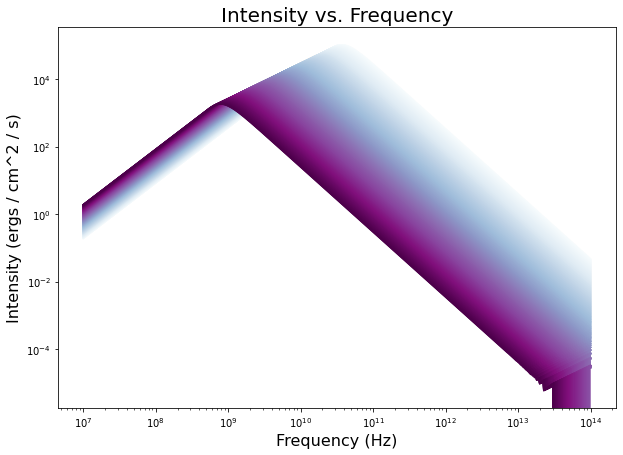

In [6]:
cmap = cm.BuPu

fig_I_nu = plt.figure(figsize=(10,7))
for i, r in enumerate(r_values):
    color = cmap(float(i) / len(r_values))
    plt.loglog(nu_values, I_syn(nu_values, r, dr_values) / (h * nu_values), color = color)
plt.title('Intensity vs. Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Intensity (ergs / cm^2 / s)')
plt.show()


# Obtaining a photon distribution
The first step to be able to use the Monte Carlo tutorial is to obtain a probability distribution function (PDF) for the photons in the jet. Using the code that calculated the flux, we will do so in the following steps:

1. Plot the intensity of the first slice
    * The intensity of each slice is already calculated in the code we wrote for the flat jet spectrum. We use that value, making sure we only plot the intensity of the first slice.
2. Move from the intensity to a unit with number of photons
3. Normalise
    * Now we need to normalise the area under the curve, this is done by dividing the number of photons array, by the area under the graph.
4. Sample the distribution

In [20]:
def photon_dist(nu, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    This function calculates the distribution of photons
    over a range of frequencies and radii.

    Parameters
    ----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    photon_dist: np.ndarray
        un-normalized photon distribution.
    """

    I_nu = I_syn(nu, r, dr, Lj, v, beta_plasma, p)
    photon_dist = I_nu / h * nu

    return photon_dist

def photon_pdf(nu, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):

    photons = photon_dist(nu, r, dr, Lj, v, beta_plasma, p)
    return photons / np.sum(photons)

def sample_photons(n, nu, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    This function samples a previously obtained, normalised photon distribution.

    Parameters
    ----------
    n : int
        the number of photons to be sampled
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution


    Returns
    -------
    v_inv: ndarray
        Sampled photon distribution.
    """
    photons = photon_dist(nu, r, dr, Lj, v, beta_plasma, p)
    photon_pdf = photons / np.sum(photons)

    photon_cdf = np.cumsum(photon_pdf)
    u = np.random.uniform(0, 1, size = n)
    v_inv = np.interp(u, photon_cdf, nu)

    return v_inv

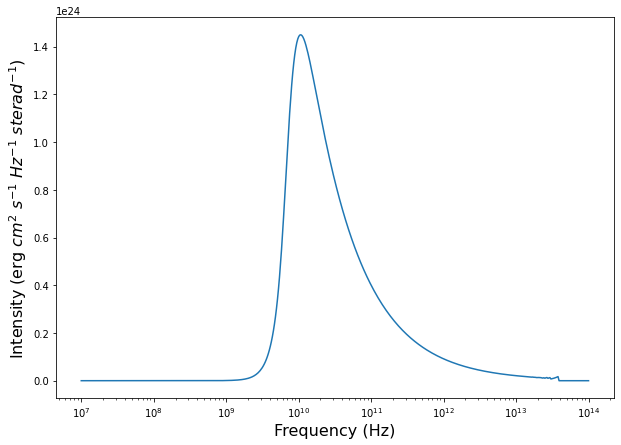

In [8]:
fig1 = plt.figure(figsize=(10, 7))
N_phot = photon_dist(nu_values, r_values, dr_values)

plt.semilogx(nu_values, N_phot)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Intensity (erg $cm^2$ $s^{-1}$ $Hz^{-1}$ $sterad^{-1}$)', fontsize=16)

plt.show()

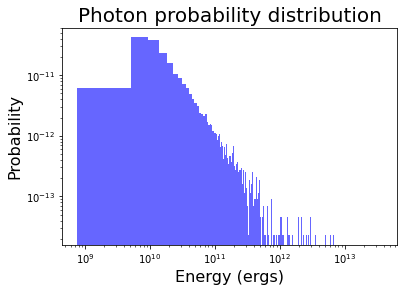

In [9]:
photon_pdf_samples = sample_photons(10000, nu_values, r_values, dr_values)

fig_photon_pdf = plt.figure()
plt.hist(photon_pdf_samples, bins= 'auto', density=True, alpha=0.6, color='b', log=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (ergs)')
plt.ylabel('Probability')
plt.title('Photon probability distribution', fontsize=20)
plt.show()

# Obtaining an electron ditribution

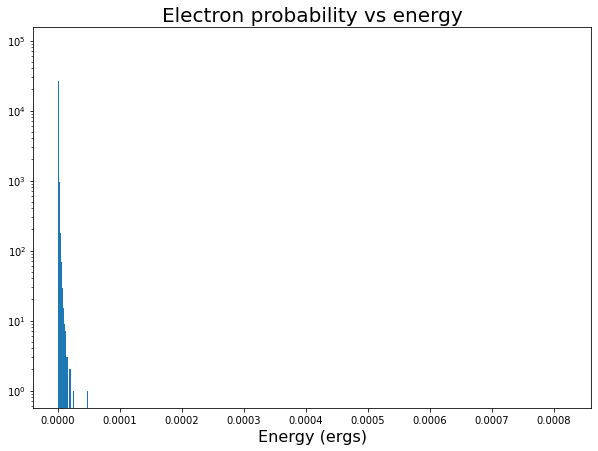

/var/folders/87/887r9j4n48n7tz26ht1lsgl40000gn/T/ipykernel_25856/3781478436.py:115: RuntimeWarning: invalid value encountered in sqrt
  vel_arr = c * np.sqrt(1 - gamma**(-2))


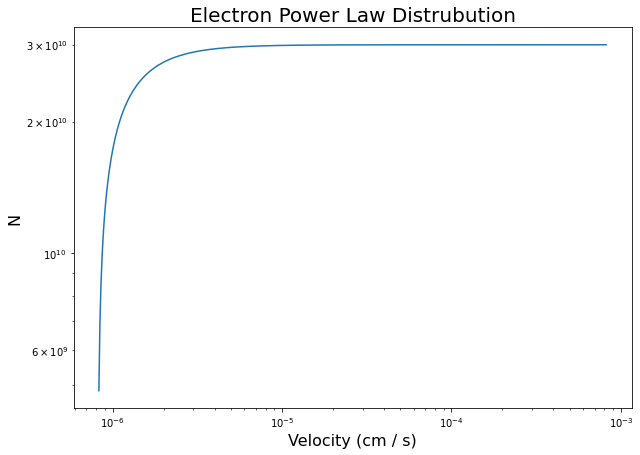

In [21]:
def electron_power_law(E, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    Calculates a power law distribution for the electrons inside of the jet.

    Parameters
    ----------
    E: np.ndarray
        an array of electron energies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    e_dist: ndarray
        Electron distribution.
    """

    constant = Constant(r, Lj, v, beta_plasma)
    C_hat = m_e * c**2 * constant
    e_dist = C_hat * E**(-p)
    return e_dist

def electron_pdf(E, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):

    electron_dist = electron_power_law(E, r, dr, Lj, v, beta_plasma, p)
    return electron_dist / np.sum(electron_dist)

def sample_electrons(n, E, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):

    """
    Adapted from demo.ipynb. Samples the electron distribution.

    Parameters
    ----------
    n : int
        the number of electrons to be sampled
    E: np.ndarray
        an array of electron energies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution
    Returns
    -------
    v_inv: ndarray
        Sampled electron distribution.
    """

    electron_dist = electron_power_law(E, r, dr, Lj, v, beta_plasma, p)
    electron_pdf = electron_dist / (np.sum(electron_dist))

    cdf = np.cumsum(electron_pdf)
    u = np.random.uniform(0, 1, size = n)
    v_inv = np.interp(u, cdf, E)
    return v_inv


electron_pdf_sample = sample_electrons(int(1e6), E_e, r_values, dr_values)

fig3 = plt.figure(figsize=(10, 7))
plt.hist(electron_pdf_sample, bins = E_e)
plt.title('Electron probability vs energy')
plt.xlabel('Electron probability')
plt.xlabel('Energy (ergs)')
plt.yscale('log')
plt.yscale('log')
plt.show()


def electron_velocities(n, E, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    Calculates the velocities of the sampled electrons.

    Parameters
    ----------
    n : int
        the number of electrons to be sampled
    E: np.ndarray
        an array of electron energies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    v: ndarray
        Velocity array.
    """

    gamma = E / (m_e * c**2)
    vel_arr = c * np.sqrt(1 - gamma**(-2))

    return vel_arr

vel_arr = electron_velocities(10000, E-e, r_values, dr_values)
fig4 = plt.figure(figsize=(10, 7))
plt.plot(E_e, vel_arr)
plt.xscale('log')
plt.yscale('log')
plt.title('Electron Power Law Distrubution')
plt.xlabel('Velocity (cm / s)')
plt.ylabel('N')
plt.show()

In [18]:
def pull_samples(pdf, a, b, n):
    '''
    Draw n samples out of a probability distribution function

    Parameters
    ----------
    pdf (func: x (float) -> float): The probability distribution function (not necessarily normalized)
    a (float): The minimum value of the pdf parameter "x"
    b (float): The maximum value of the pdf parameter "x"

    Returns
    -------
    x_sampled: np.ndarray
    '''

    x = np.linspace(a, b, 10000, endpoint = True)
    npdf = pdf(x)/np.sum(pdf(x)) #normalized pdf: npdf(x) = pdf(x)/(\int_a^b pdf(x)*dx)
    Ipdf = np.cumsum(npdf) #Integrated probability: P(x) = \int_0^x npdf(t)*dt
    P = np.random.uniform(0, 1, size = n)
    x_sampled = np.interp(P, Ipdf, x)
    
    return x_sampled

def f_of_v_powerlaw(mc_parms, number = 1):
    gamma = pull_samples(electron_pdf, 1, 1000, number)
    return (1-1/gamma**2)*c

# Monte Carlo simulation
Now, having written the electron and photon sampling functions we are able to feed it back to our MC simulation.

In [19]:
c_light=3.e10
m_electron=9.10938356e-28
sigma_t=6.65e-25
figure_counter=0

def compton_y(pre, post):
    """
    This function calculates the Compton Y parameter.

    Parameters
    -----------
    pre : 
    post :

    Returns
    -----------
    Y : 
        Compton Y parameter
    """
    y = np.mean((post-pre)/pre)
    return(y)

def random_direction(number=None):
    """
    
    """
    if number is None:
        number=1
    phi=np.random.rand(number)*2.*np.pi
    cos_theta=2.*np.random.rand(number)-np.ones(number)
    sin_theta= np.sqrt(1-cos_theta**2)
    return((np.array([sin_theta*np.cos(phi),sin_theta*np.sin(phi),cos_theta])).transpose())

def f_of_hnu_mono(mc_parms,number=None):
    if number is None:
        number=1
    return(np.ones(number)*mc_parms['kt_seeds'])

def photon_origin(number=None):
    if number is None:
        number=1
    return(np.zeros([number,3]))

def draw_seed_photons(mc_parms,number=None):
    if number is None:
        number=1
    x_seed=photon_origin(number=number)
    n_seed=random_direction(number=number)
    hnu=mc_parms['hnu_dist'](mc_parms,number=number)
    p_seed=(np.array([hnu,hnu*n_seed[:,0],hnu*n_seed[:,1],hnu*np.abs(n_seed[:,2])])).transpose()/c_light
    return(p_seed,x_seed)

def tau_of_scatter():
    return(-np.log(np.random.rand()))

def distance_of_scatter(mc_parms):
    tau=tau_of_scatter()
    electron_density=mc_parms['tau']/mc_parms['H']/sigma_t
    distance=tau/sigma_t/electron_density
    return(distance)

def scatter_location(x_old,p_photon,mc_parms):
    distance = distance_of_scatter(mc_parms)
    photon_direction=p_photon[1:]/p_photon[0]
    x_new = x_old + distance*photon_direction
    return(x_new)

def f_of_v_mono(mc_parms):
    return(mc_parms['velocity'])

def draw_electron_velocity(mc_parms,p_photon):
    v=mc_parms['v_dist'](mc_parms)
    n=draw_electron_direction(v,p_photon)
    return(v*n)

def draw_electron_direction(v,p_photon):
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=mu_of_p_electron(v/c_light,np.random.rand())
    sint=np.sqrt(1 - cost**2)

    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    # express new vector in old base
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    return(n_new/np.sqrt(np.sum(n_new**2)))

def mu_of_p_electron(b,p):
    mu=(4*p-2-b)/(1+np.sqrt(1+b*(2-4*p)+b**2))
    return(mu)

def lorentz_transform(p,v):
    beta=np.sqrt(np.sum(v**2))/c_light
    beta_vec=v/c_light
    gamma=1./np.sqrt(1. - beta**2)
    matrix=np.zeros((4,4))
    matrix[0,0]=gamma
    matrix[1:,0]=-gamma*beta_vec
    matrix[0,1:]=-gamma*beta_vec
    matrix[1:,1:]=(gamma-1)*np.outer(beta_vec,beta_vec)/beta**2
    for i in range(1,4):
        matrix[i,i]+=1
    return(np.dot(matrix,p))

def cos_theta_thomson(p):
    a=-4 + 8*p
    b=a**2 + 4
    return((np.power(2,1/3)*np.power(np.sqrt(b)-a,2/3)-2)/
           (np.power(2,2/3)*np.power(np.sqrt(b)-a,1/3)))

def thomson_scatter(p_photon):
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=cos_theta_thomson(np.random.rand())
    sint=np.sqrt(1 - cost**2)
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    n_new/=np.sqrt(np.sum(n_new**2))
    return(np.array(p_photon[0]*np.array([1,n_new[0],n_new[1],n_new[2]])))

def inverse_compton_scatter(p_photon,mc_parms):
    velocity=draw_electron_velocity(mc_parms,p_photon)
    p_photon_prime=lorentz_transform(p_photon,velocity)
    p_out_prime=thomson_scatter(p_photon_prime)
    return(lorentz_transform(p_out_prime,-velocity))

def monte_carlo(mc_parms):
    hnu_seed=np.zeros(mc_parms['n_photons'])
    hnu_scattered=hnu_seed.copy()
    p_photons,x_photons=draw_seed_photons(mc_parms,number=mc_parms['n_photons'])
    for p_photon,x_photon,i in zip(p_photons,x_photons,range(mc_parms['n_photons'])):
        hnu_seed[i]=p_photon[0]*c_light
        scattered=True
        while (scattered):
            x_photon = scatter_location(x_photon,p_photon,mc_parms)
            if (x_photon[2]>=0 and x_photon[2]<=mc_parms['H']):
                p_photon=inverse_compton_scatter(p_photon,mc_parms)
            else:
                scattered=False
                if (x_photon[2]<=0):
                    p_photon*=0
        hnu_scattered[i]=p_photon[0]*c_light
    return(hnu_scattered[hnu_scattered > 0],hnu_seed[hnu_scattered > 0])

def plot_mc(mc_parms,bins=None,xlims=None,filename=None):
    global figure_counter
    if (xlims is None):
        xlims=[0.1,100]
    if (bins is None):
        bins=np.logspace(np.log10(hnu_scattered.min()),np.log10(hnu_scattered.max()),num=100)
    if (filename is None):
        filename='inverse_compton_MC_{0:d}.pdf'.format(figure_counter)
    hnu_scattered,hnu_seeds=np.array(monte_carlo(mc_parms))/mc_parms['kt_seeds']
    fig=plt.figure()
    plt.hist(hnu_scattered,bins=bins, log=True,
             label=r'$\tau=${:4.1f}'.format(mc_parms['tau']))
    plt.xscale('log')
    # plt.xlim(xlims[0],xlims[1])
    plt.xlabel(r'$h\nu/h\nu_{0}$')
    plt.ylabel(r'$N(h\nu)$')
    plt.legend()
    fig.savefig(filename)
    figure_counter+=1
    plt.show()
    print('Fraction of escaping photons: {0:5.3e}\n'.format(hnu_scattered.size/mc_parms['n_photons']))
    print('Compton y parameter: {0:5.3e}\n'.format(compton_y(hnu_seeds,hnu_scattered)))
    return(hnu_scattered,hnu_seeds)

In [ ]:
# Some extra functions that will let us feed it the output of the sampling into the MC.
def f_of_v_powerlaw(mc_parms, no_e = no_e, E = E):
    """
    Applies the MC parameters to the electron distribution.

    Parameters
    ----------
    mc_parms: dict
        MC parameters

    no_e: ndarray
        Array of electron

    E: ndarray
        Energy array

    Returns
    -------
    samples: ndarray
        Sample array.
    """
    r = np.random.rand()
    g = (1-r)**(1/(1-2))
    b = 1 - 1/g**2
    return b*c
    n = 1
    samples = sample_electrons(n, no_e, E)
    samples = electron_v(E, m_e)

    return samples


def f_of_jet_slice(mc_parms, r=r, dr = dr_values, nu = nu_values, number=None,pdf=None,energies=None):
    if number == None:
        number = 1
    n = number
    jet_pdf = jet_spectrum(r, dr, nu)
    samples = photon_distr(n, jet_spectrum, nu_values)

    return samples

In [23]:
# now we just put everything together
# Run an example of a Monte Carlo simulation for optical depth 0.1

mc_parms={'n_photons':int(1e4),         # start somewhat small and go up
            'kt_seeds':1.6e-9,         # 1 keV input photons
            'H':r_values[0],                   # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
            'velocity':3e10 * 0.3,            # 10% speed of light--pretty hot
            'tau':0.1,                 # tau ~ 0.1: Small-ish optical depth # t=1 for photosphere
            'v_dist':sample_electrons,      # name of velocity distribution function
            'gamma_min': 0,
            'gamma_max': 3, # range for electron gamma 1e0 to 1e3
            'hnu_dist':sample_photons,  # name of photon distribution function
            }

hnu_scattered, hnu_seeds=plot_mc(mc_parms, bins=nu_values, xlims=[1, 1e10])
                                 

TypeError: sample_photons() got an unexpected keyword argument 'number'

This is how far I managed to get, figuring out how to use the MC properly and how to sample the  distributions took way longer than I wanted it to.